# Introduction

Financial markets often experience abrupt changes in volatility that can disrupt trading strategies, impact hedging decisions and significantly affect short-term risk management. Anticipating these volatility spikes is a recurring challenge for traders, portfolio managers, market-makers and risk teams. Traditional indicators such as simple returns or technical signals offer limited insight when market conditions shift rapidly. As a result, forecasting volatility regimes has become a key research area in quantitative finance.

The objective of this notebook is to build a supervised machine learning model capable of identifying whether the market is likely to experience a significant volatility increase on the following day. We use the VIX index as a proxy for market fear and derive a binary target that labels the top 20% largest next-day VIX increases as “volatility spikes”. This framing transforms a noisy financial problem into a well-defined classification task aligned with the practical needs of short-horizon decision-making.

To support the model, we engineer a comprehensive set of features capturing price momentum, realized volatility, intraday stress, abnormal volume activity and VIX behavior. Each feature group is analyzed through detailed exploratory data analysis to understand its distribution, temporal evolution and potential predictive value. A clean, leakage-free target is constructed with strict chronological discipline.

Using these features, we design a complete modeling pipeline with chronological train/validation/test splits and TimeSeriesSplit cross-validation. Several models are evaluated (including Logistic Regression, Random Forest and Gradient Boosting) to assess how well different learning methods can anticipate next-day volatility shifts. The results provide insight into both the potential and the limitations of short-term volatility forecasting using market-derived variables.

This notebook follows industry best practices for time-series modeling and offers a realistic perspective on the challenges and feasibility of predicting volatility regime changes.

In [1]:
!pip install yfinance


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install scipy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
#Import Librairies
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro

In [4]:
#Import Data
spx = yf.download("^GSPC", start="2000-01-01", end= "2025-09-01")
vix = yf.download("^VIX", start="2000-01-01", end= "2025-09-01")

/tmp/ipykernel_1462/394266287.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx = yf.download("^GSPC", start="2000-01-01", end= "2025-09-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1462/394266287.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2000-01-01", end= "2025-09-01")
[*********************100%***********************]  1 of 1 completed


In [5]:
#Data Cleaning
spx = spx.rename(columns={
    "Open": "SPX_Open",
    "High": "SPX_High",
    "Low": "SPX_Low",
    "Close": "SPX_Close",
    "Volume": "SPX_Volume"
})

vix = vix.rename(columns={
    "Open": "VIX_Open",
    "High": "VIX_High",
    "Low": "VIX_Low",
    "Close": "VIX_Close",
    "Volume": "VIX_Volume"
})

#Merge 2 Dataset
df = spx.merge(vix, left_index=True, right_index=True, how="inner")
df.columns = df.columns.droplevel(1)

df.head()

#Drop NA
df = df.dropna()

#Reset Index
df = df.reset_index()


#Transform date en date.time
df["Date"] = pd.to_datetime(df["Date"])

# Final check
print(df.head())
print(df.info())

Price       Date    SPX_Close     SPX_High      SPX_Low     SPX_Open  \
0     2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   
1     2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971   
2     2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044   
3     2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985   
4     2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951   

Price  SPX_Volume  VIX_Close   VIX_High    VIX_Low   VIX_Open  VIX_Volume  
0       931800000  24.209999  26.150000  23.980000  24.360001           0  
1      1009000000  27.010000  27.180000  24.799999  24.940001           0  
2      1085500000  26.410000  29.000000  25.850000  27.980000           0  
3      1092300000  25.730000  26.709999  24.700001  26.680000           0  
4      1225200000  21.719999  25.170000  21.719999  25.139999           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 11 columns):
 #  

The dataset is now fully cleaned and ready for feature engineering. All price and volatility fields from the S&P 500 and the VIX are properly loaded as numerical types, the date column has been converted to a datetime index and no missing values remain. The structure confirms that we have a complete and consistent daily dataset, which provides a solid foundation for computing returns, volatility measures and all other features required for our analysis.

In [6]:
#Data validation
df.shape

(6454, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        6454 non-null   datetime64[ns]
 1   SPX_Close   6454 non-null   float64       
 2   SPX_High    6454 non-null   float64       
 3   SPX_Low     6454 non-null   float64       
 4   SPX_Open    6454 non-null   float64       
 5   SPX_Volume  6454 non-null   int64         
 6   VIX_Close   6454 non-null   float64       
 7   VIX_High    6454 non-null   float64       
 8   VIX_Low     6454 non-null   float64       
 9   VIX_Open    6454 non-null   float64       
 10  VIX_Volume  6454 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 554.8 KB


In [8]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Price,,,,,,,,
Date,6454,2012-10-30 20:49:27.462039296,2000-01-03 00:00:00,2006-06-05 06:00:00,2012-10-28 12:00:00,2019-03-31 06:00:00,2025-08-29 00:00:00,NaN
SPX_Close,6454.0,2210.202197,676.530029,1207.01001,1514.11499,2840.66748,6501.859863,1369.899107
SPX_High,6454.0,2222.569333,695.27002,1213.867493,1520.424988,2853.71759,6508.22998,1376.034232
SPX_Low,6454.0,2196.168279,666.789978,1198.897491,1504.434998,2823.065002,6466.959961,1362.62008
SPX_Open,6454.0,2209.838853,679.280029,1206.972473,1513.590027,2840.642517,6489.279785,1369.514658
SPX_Volume,6454.0,3394454598.698482,0.0,2283305000.0,3515270000.0,4233397500.0,11456230000.0,1504491134.082533
VIX_Close,6454.0,19.871838,9.14,13.96,17.84,23.285001,82.690002,8.411525
VIX_High,6454.0,20.922333,9.31,14.6225,18.74,24.5,89.529999,9.062326
VIX_Low,6454.0,19.10784,8.56,13.5,17.15,22.42,72.760002,7.864143


In [9]:
df.isna().sum()
df["Date"].is_unique

True

# EDA

Even before looking at the data, certain S&P 500 variables are known in market finance to have a direct impact on implied volatility (and therefore on the VIX). We start from a list of determined features derived from market theory and microstructure.

1. Price Returns (Momentum Signals)

Why: the most fundamental way to capture recent market direction.

ret_1d : daily return

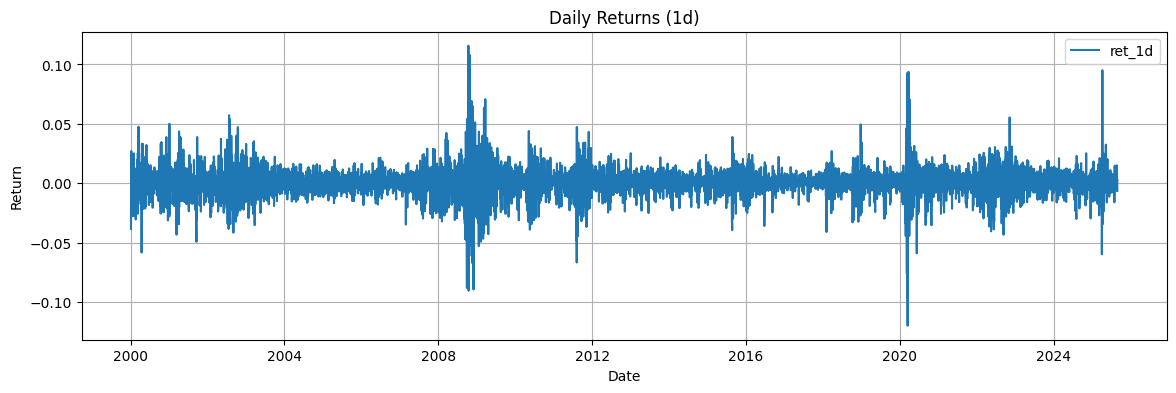

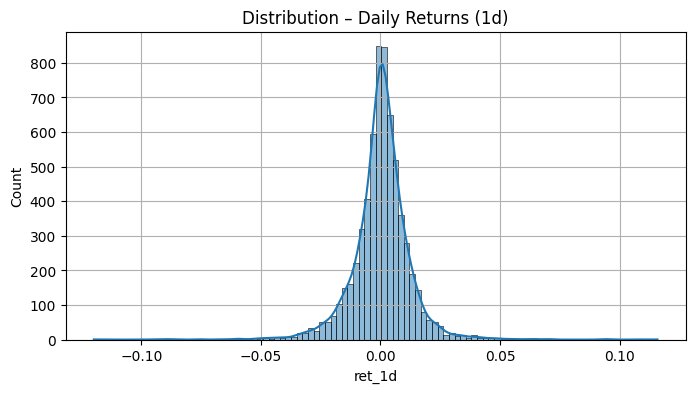

Skewness : -0.11727043429899725
Kurtosis : 13.424555003426455
Shapiro-Wilk normality p-value : 0.0


In [34]:
# Day-to-day percentage change in SPX closing price
df["ret_1d"] = df["SPX_Close"].pct_change(1)

# Drop NA values
r = df["ret_1d"].dropna()

# Plot daily returns as a time series
plt.figure(figsize=(14,4))
plt.plot(df["Date"], df["ret_1d"], label="ret_1d")
plt.title("Daily Returns (1d)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.show()

# Plot distribution of daily returns
plt.figure(figsize=(8,4))
sns.histplot(df["ret_1d"], bins=100, kde=True)
plt.title("Distribution – Daily Returns (1d)")
plt.grid(True)
plt.show()

# Statistical properties
print("Skewness :", skew(r))
print("Kurtosis :", kurtosis(r, fisher=False))
stat, p = shapiro(r.sample(5000))
print("Shapiro-Wilk normality p-value :", p)

Although the distribution of daily returns appears visually close to a normal law at the center, statistical analysis reveals a very different reality.
The slightly negative skewness indicates that extreme downside moves occur more frequently than upside moves, while the extremely high kurtosis (≈ 13.4) highlights the presence of very fat tails. The Shapiro–Wilk test confirms the complete non-normality of the distribution. These results demonstrate the presence of fat tails and volatility clustering, two essential characteristics of financial markets that play a key role in the formation of volatility spikes (VIX). This fully justifies the use of nonlinear models (such as Gradient Boosting) and volatility-focused features that capture market shocks and instability.

ret_5d : weekly return

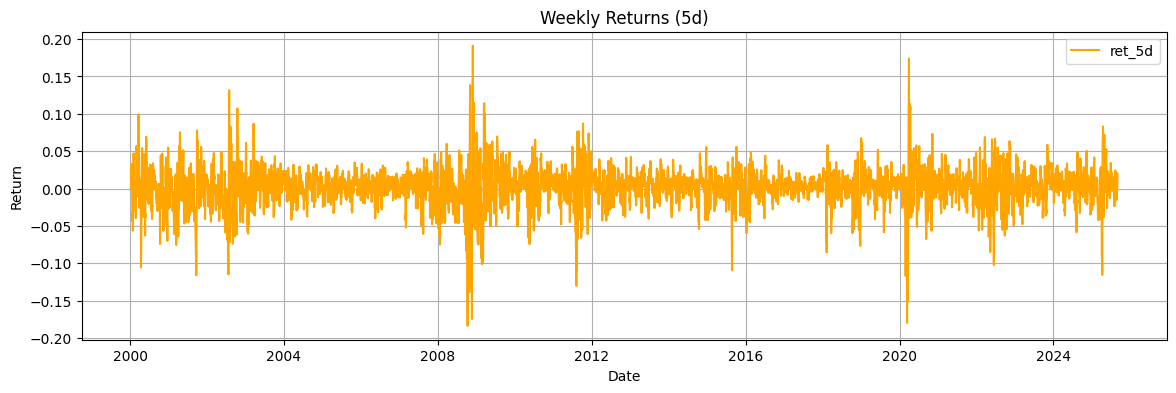

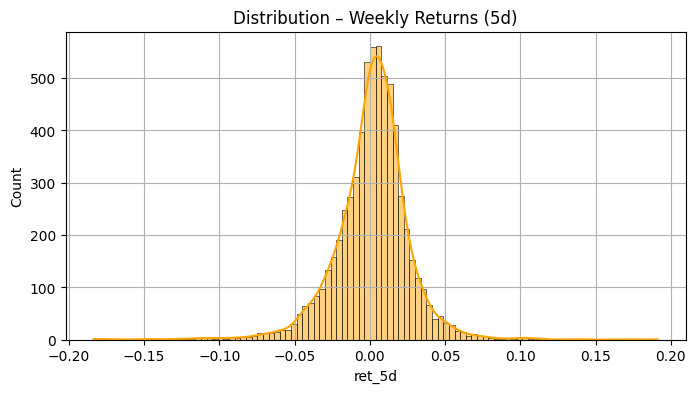

Skewness : -0.5747762613547821
Kurtosis : 9.042329711070218
Shapiro-Wilk normality p-value : 4.114212291257663e-42


In [46]:
# Percentage change over the last 5 trading days
df["ret_5d"] = df["SPX_Close"].pct_change(5)

# Drop NA
t = df["ret_5d"].dropna()

# Plot weekly returns as a time series
plt.figure(figsize=(14,4))
plt.plot(df["Date"], df["ret_5d"], label="ret_5d", color="orange")
plt.title("Weekly Returns (5d)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.show()

# Plot distribution of daily returns
plt.figure(figsize=(8,4))
sns.histplot(df["ret_5d"], bins=100, kde=True, color="orange")
plt.title("Distribution – Weekly Returns (5d)")
plt.grid(True)
plt.show()

# Statistical properties
print("Skewness :", skew(t))
print("Kurtosis :", kurtosis(t, fisher=False))
stat, p = shapiro(t.sample(5000))
print("Shapiro-Wilk normality p-value :", p)

Weekly returns display much larger movements than daily returns, with a strong presence of extreme events and a clear downside asymmetry.
The very high kurtosis (≈ 9) reflects fat tails typical of financial markets, confirming that weekly variations do not follow a normal distribution.
The Shapiro–Wilk test formally rejects normality. These properties, downside asymmetry, frequent extremes, and volatility clustering, are essential in volatility prediction, as weekly returns capture cumulative stress signals. Weekly returns are therefore a relevant variable for anticipating volatility regime shifts and potential VIX spikes.

ret_20d : monthly return

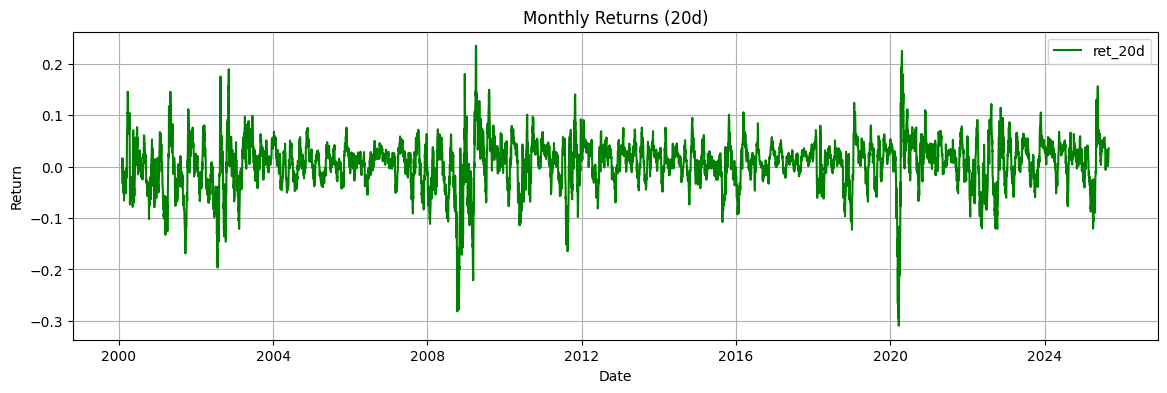

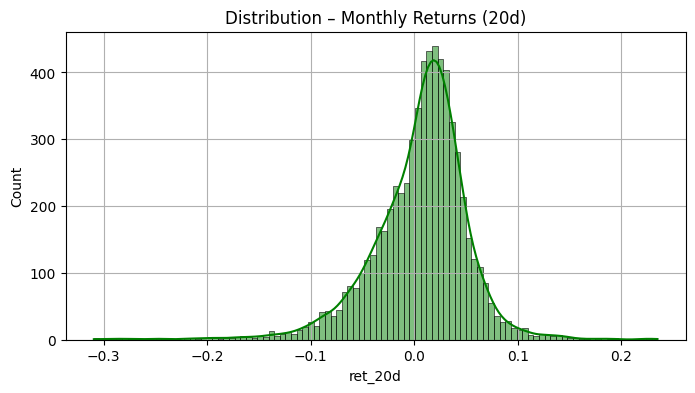

Skewness : -0.5747762613547821
Kurtosis : 9.042329711070218
Shapiro-Wilk normality p-value : 0.0


In [58]:
# Percentage change over 20 trading days (~1 month)
df["ret_20d"] = df["SPX_Close"].pct_change(20)

# Drop NA values for statistical calculations
s = df["ret_5d"].dropna()

# Plot time series of 20d returns
plt.figure(figsize=(14,4))
plt.plot(df["Date"], df["ret_20d"], label="ret_20d", color="green")
plt.title("Monthly Returns (20d)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.show()

# Plot distribution of 20d returns
plt.figure(figsize=(8,4))
sns.histplot(df["ret_20d"], bins=100, kde=True, color="green")
plt.title("Distribution – Monthly Returns (20d)")
plt.grid(True)
plt.show()

# Statistical properties
print("Skewness :", skew(s))
print("Kurtosis :", kurtosis(s, fisher=False))
stat, p = shapiro(r.sample(5000))
print("Shapiro-Wilk normality p-value :", p)

Monthly returns exhibit much larger and more asymmetric fluctuations than daily or weekly horizons. They capture volatility regimes very clearly and display extremely fat tails (kurtosis ≈ 9) along with a pronounced downside asymmetry (negative skewness). The Shapiro–Wilk test further confirms the non-normality of the distribution. These properties indicate that 20-day cumulative movements contain strong information about market stress conditions. As a result, 20-day returns are a valuable indicator for understanding periods of accelerating risk and the conditions that precede panic episodes in which the VIX spikes.

In [13]:
# Drop NaNs caused by pct_change
df_returns = df[["ret_1d", "ret_5d", "ret_20d"]].dropna()
df_returns.head()

Price,ret_1d,ret_5d,ret_20d
20,0.010628,-0.000532,-0.031569
21,-0.000114,0.003582,0.006931
22,0.011248,0.018884,0.016304
23,-0.000421,0.047208,0.014906
24,-0.000091,0.021356,-0.011953


In [14]:
df.head(100)

Price,Date,SPX_Close,SPX_High,SPX_Low,SPX_Open,SPX_Volume,VIX_Close,VIX_High,VIX_Low,VIX_Open,VIX_Volume,ret_1d,ret_5d,ret_20d
0,2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000,24.209999,26.150000,23.980000,24.360001,0,NaN,NaN,NaN
1,2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,27.010000,27.180000,24.799999,24.940001,0,-0.038345,NaN,NaN
2,2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,26.410000,29.000000,25.850000,27.980000,0,0.001922,NaN,NaN
3,2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,25.730000,26.709999,24.700001,26.680000,0,0.000956,NaN,NaN
4,2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,21.719999,25.170000,21.719999,25.139999,0,0.027090,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2000-05-18,1437.209961,1458.040039,1436.589966,1447.800049,807900000,23.959999,24.030001,23.290001,23.420000,0,-0.007315,0.020883,0.006823
96,2000-05-19,1406.949951,1437.209961,1401.739990,1437.209961,853700000,25.440001,26.150000,24.850000,24.850000,0,-0.021055,-0.009860,-0.019233
97,2000-05-22,1400.719971,1410.550049,1368.729980,1406.949951,869000000,26.000000,27.900000,25.980000,26.250000,0,-0.004428,-0.035556,-0.020380
98,2000-05-23,1373.859985,1403.770020,1373.430054,1400.719971,869900000,25.870001,26.120001,24.969999,25.750000,0,-0.019176,-0.062877,-0.070108


In [15]:
df_returns.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,,,,,,,,
ret_1d,6434.0,0.000313,0.012236,-0.119841,-0.004749,0.000634,0.005912,0.115800
ret_5d,6434.0,0.001503,0.024747,-0.183401,-0.009985,0.003110,0.014647,0.191112
ret_20d,6434.0,0.005799,0.046407,-0.309439,-0.016765,0.011964,0.032542,0.234949


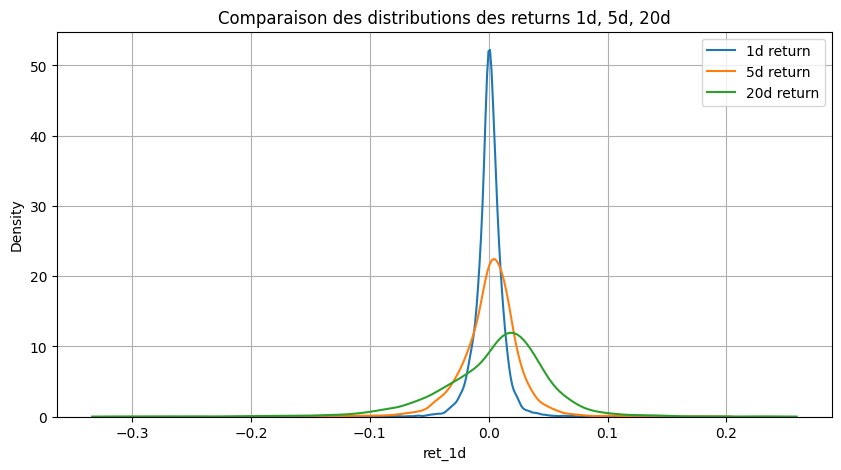

In [16]:
plt.figure(figsize=(10,5))
sns.kdeplot(df["ret_1d"], label="1d return")
sns.kdeplot(df["ret_5d"], label="5d return")
sns.kdeplot(df["ret_20d"], label="20d return")
plt.legend()
plt.title("Comparaison des distributions des returns 1d, 5d, 20d")
plt.grid(True)
plt.show()

Our EDA on multi-horizon returns (1d, 5d, 20d) shows that market data is non-Gaussian, asymmetric, and dominated by extreme events and volatility regimes. These characteristics justify the use of Gradient Boosting, which is specifically suited to capturing non-linear and regime-dependent patterns that linear models cannot learn.

2. Realized Volatility (Market Instability)

Why: volatility regime shifts usually follow periods of rising realized vol.

rv_30d : medium-term realized volatility

The variable rv_30d corresponds to medium-term realized volatility:
- the standard deviation of daily returns over a 30-day rolling window,
- annualized using √252.

It measures the market’s actual instability over recent weeks.

In [97]:
# Creation of a new dataframe for the realized volatility based on the existing returns
df_vol = df[["ret_1d"]].copy()

In [100]:
# Medium-term realized volatility (30-day rolling std, annualized)
df_vol["rv_30d"] = (
    df_vol["ret_1d"]
    .rolling(window=30, min_periods=30)
    .std() * np.sqrt(252)
)

In [103]:
#clean NaNs
df_vol = df_vol[["rv_30d"]].dropna()
df_vol.head()

Price,rv_30d
30,0.236436
31,0.210627
32,0.210540
33,0.227858
34,0.212287


The levels are around 21%–23% annualized. This corresponds to a market in moderate stress (e.g., episodic crises, elevated volatility). It is not a calm regime (which would be < 10–12%). This shows that, already in the early 2000s, the market was experiencing a relatively elevated volatility regime.

In [106]:
df_vol.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,,,,,,,,
rv_30d,6424.0,0.165925,0.103425,0.035667,0.102487,0.136643,0.202419,0.853095


The 30-day realized volatility shows that the S&P frequently transitions between calm (<10%), normal (10–17%), and stress regimes (>17%), highlighting a structurally volatile market. The large dispersion (std ≈ 10%) confirms that markets can shift abruptly from stability to panic, the exact behavior amplified by the VIX.

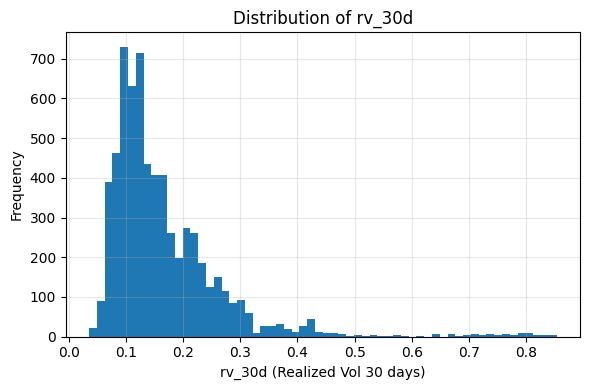

In [112]:
# Histogram for 30-day realized volatility
plt.figure(figsize=(6,4))

plt.hist(df_vol["rv_30d"], bins=60)
plt.title("Distribution of rv_30d")
plt.grid(True, alpha=0.3)

plt.xlabel("rv_30d (Realized Vol 30 days)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


The distribution of 30-day realized volatility is heavily right-skewed, with most observations in calm or normal regimes but a long tail of extreme values, confirming the presence of rare but intense volatility spikes.

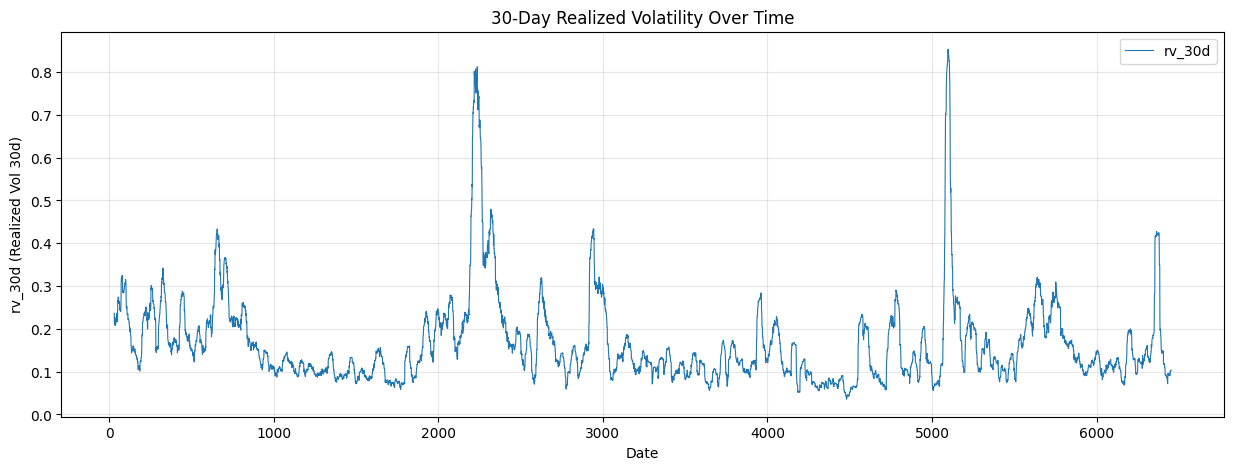

In [115]:
#Time series plot
plt.figure(figsize=(15,5))
plt.plot(df_vol.index, df_vol["rv_30d"], label="rv_30d", linewidth=0.8)
plt.title("30-Day Realized Volatility Over Time")
plt.ylabel("rv_30d (Realized Vol 30d)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The time series shows clear volatility regimes and strong clustering: long periods of low volatility interrupted by sudden surges during market crises, highlighting how turbulence builds before major VIX spikes.

3. Intraday Behavior (Nervousness Signals)

Why: captures instability inside the day, unobservable in returns.

range : intraday amplitude

open_gap : overnight surprise

In [124]:
df.columns

Index(['Date', 'SPX_Close', 'SPX_High', 'SPX_Low', 'SPX_Open', 'SPX_Volume',
       'VIX_Close', 'VIX_High', 'VIX_Low', 'VIX_Open', 'VIX_Volume', 'ret_1d',
       'ret_5d', 'ret_20d'],
      dtype='object', name='Price')

In [127]:
# Create a dedicated dataframe using your SPX column names
df_intraday = df[["SPX_High", "SPX_Low", "SPX_Close", "SPX_Open"]].copy()

# Intraday amplitude
df_intraday["range"] = (df_intraday["SPX_High"] - df_intraday["SPX_Low"]) / df_intraday["SPX_Close"]

# Overnight gap
df_intraday["open_gap"] = df_intraday["SPX_Open"].pct_change(1)

# Keep only the features we need
df_intraday = df_intraday[["range", "open_gap"]].dropna()

df_intraday.head()

Price,range,open_gap
1,0.041296,-0.009549
2,0.025383,-0.038345
3,0.014108,0.001922
4,0.028263,0.000956
5,0.015704,0.027090


In [130]:
df_intraday.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,,,,,,,,
range,6453.0,0.012980,0.009878,0.001456,0.006783,0.010385,0.015910,0.107382
open_gap,6453.0,0.000296,0.011450,-0.087119,-0.004483,0.000738,0.005766,0.106712


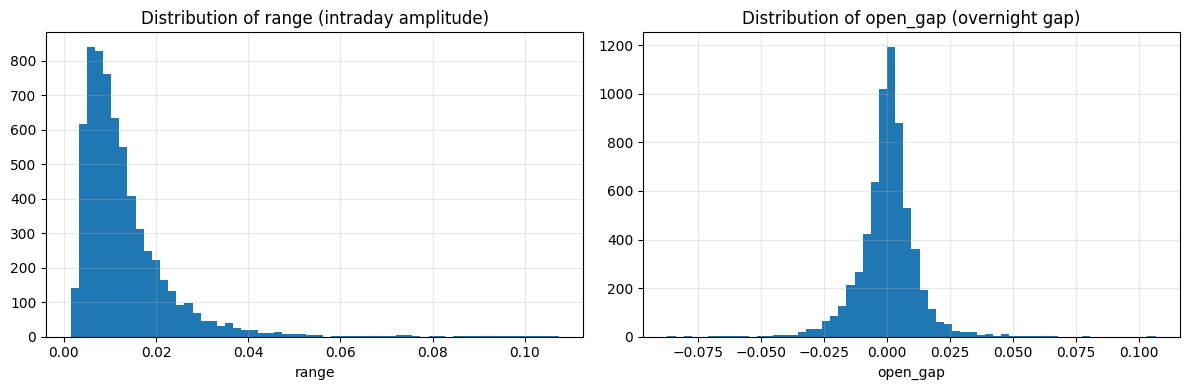

In [133]:
# Histogram visualizations for intraday instability variables
plt.figure(figsize=(12,4))

# Histogram of intraday price range
plt.subplot(1, 2, 1)
plt.hist(df_intraday["range"], bins=60)
plt.title("Distribution of range (intraday amplitude)")
plt.xlabel("range")
plt.grid(True, alpha=0.3)

# Histogram of overnight gaps
plt.subplot(1, 2, 2)
plt.hist(df_intraday["open_gap"], bins=60)
plt.title("Distribution of open_gap (overnight gap)")
plt.xlabel("open_gap")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The intraday range shows how much the price fluctuated within the session. Most days have small ranges, but the long right tail indicates that occasional high-volatility days occur, consistent with stress or major news events.

Overnight gaps capture discontinuities between the previous close and the next open. The distribution is centered close to zero, with a few large gaps caused by unexpected overnight news or macro shocks, reflecting jump-risk in prices.

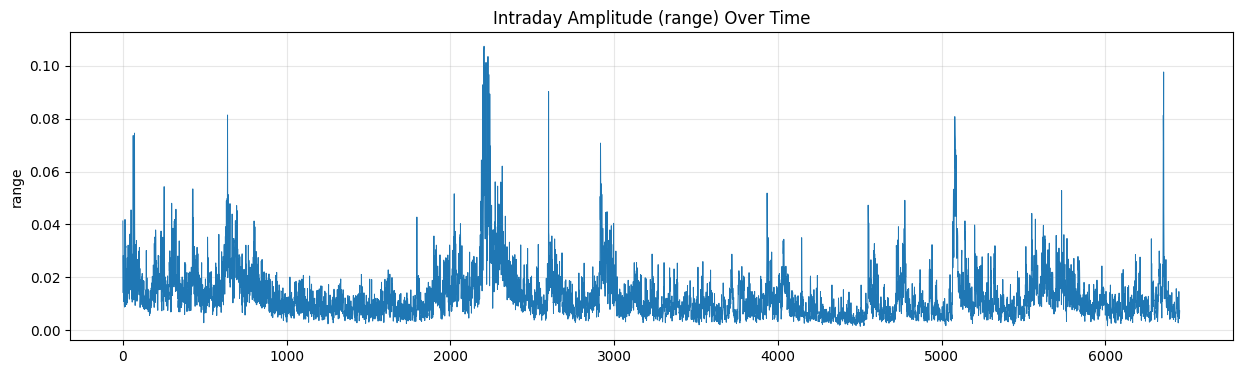

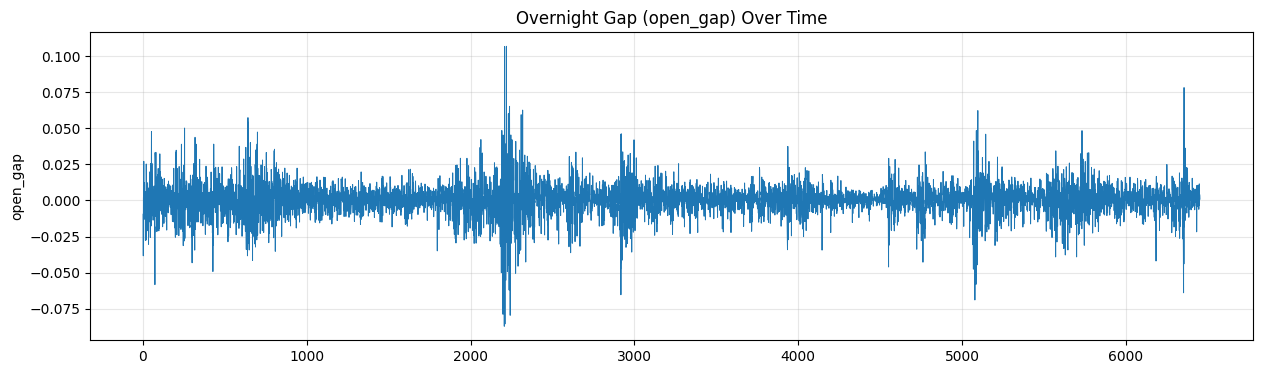

In [136]:
#Time-Series plots

# Intraday amplitude over time
plt.figure(figsize=(15,4))
plt.plot(df_intraday.index, df_intraday["range"], linewidth=0.7)
plt.title("Intraday Amplitude (range) Over Time")
plt.ylabel("range")
plt.grid(True, alpha=0.3)
plt.show()

# Overnight gap over time
plt.figure(figsize=(15,4))
plt.plot(df_intraday.index, df_intraday["open_gap"], linewidth=0.7)
plt.title("Overnight Gap (open_gap) Over Time")
plt.ylabel("open_gap")
plt.grid(True, alpha=0.3)
plt.show()


The intraday range increases sharply during stress periods, showing that price swings inside the day become much larger when market uncertainty rises. These spikes often coincide with known crisis episodes, which confirms that intraday volatility is a reliable early signal of nervous market conditions.

Large overnight gaps reflect surprise events occurring outside trading hours. They appear around major news or volatility shocks and indicate abrupt repricing. Although gaps remain small most of the time, the occasional spikes highlight their role as indicators of sudden market stress.

4. Volume Activity (Market Pressure)

Why: unusual volume = investors repositioning = early stress signal.

volume_z : volume abnormality

volume_rel : relative volume

In [148]:
#Creation of volume activity features

# Dedicated dataframe for volume features
df_volume = df[["SPX_Volume"]].copy()

# Rolling stats over 20 days
window = 20
df_volume["volume_mean_20d"] = (
    df_volume["SPX_Volume"]
    .rolling(window=window, min_periods=window)
    .mean()
)
df_volume["volume_std_20d"] = (
    df_volume["SPX_Volume"]
    .rolling(window=window, min_periods=window)
    .std()
)

# Volume z-score: abnormality vs recent history
df_volume["volume_z"] = (
    (df_volume["SPX_Volume"] - df_volume["volume_mean_20d"]) 
    / df_volume["volume_std_20d"]
)

# Relative volume: ratio vs recent average
df_volume["volume_rel"] = (
    df_volume["SPX_Volume"] / df_volume["volume_mean_20d"]
)

# Keep only the features of interest and drop NaNs
df_volume = df_volume[["volume_z", "volume_rel"]].dropna()

df_volume.head()

Price,volume_z,volume_rel
19,-1.134714,0.924706
20,-1.439147,0.910711
21,-0.611066,0.962861
22,0.962867,1.059896
23,-0.505729,0.968268


In [142]:
#Stats
df_volume.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,,,,,,,,
volume_z,6435.0,0.025112,1.074602,-3.928117,-0.688988,-0.070387,0.652240,4.040129
volume_rel,6435.0,1.004513,0.177175,0.000000,0.904953,0.991024,1.088851,2.093563


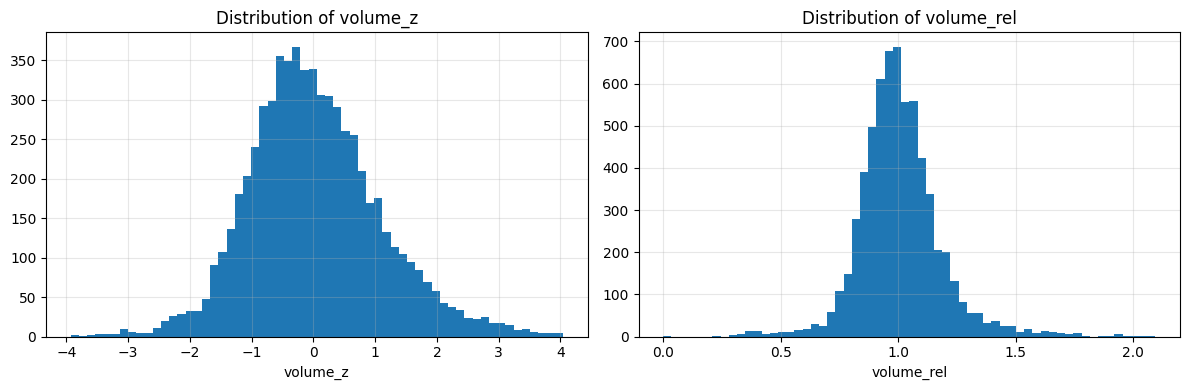

In [145]:
# Histogram
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(df_volume["volume_z"], bins=60)
plt.title("Distribution of volume_z")
plt.xlabel("volume_z")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_volume["volume_rel"], bins=60)
plt.title("Distribution of volume_rel")
plt.xlabel("volume_rel")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The Z-score of volume is centered around zero with a nearly symmetric bell shape. Most days exhibit normal trading activity, while the tails show occasional spikes in buying or selling pressure. These outliers often correspond to stress periods where investors aggressively adjust their positions.

Relative volume is concentrated around 1, which is expected since it compares daily volume to its 20-day average. Values above 1.3 indicate unusually high market participation, often preceding volatility episodes.

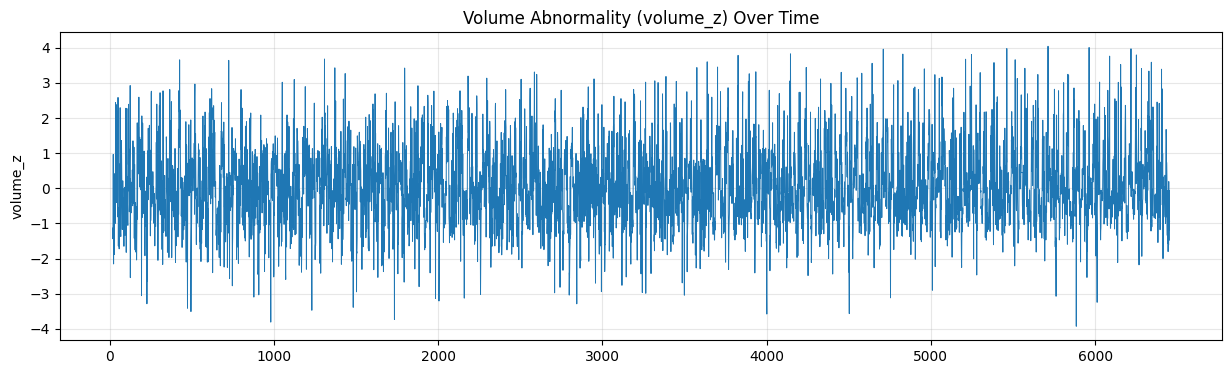

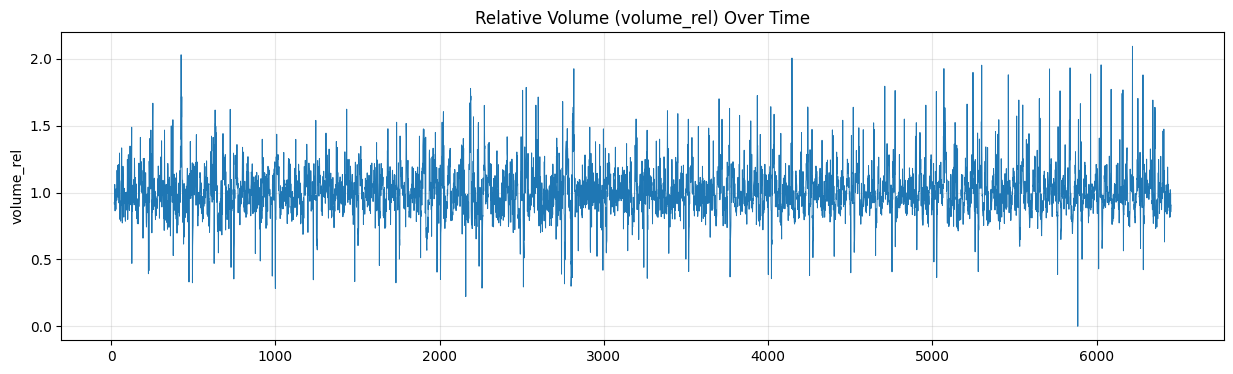

In [151]:
# Time series

plt.figure(figsize=(15,4))
plt.plot(df_volume.index, df_volume["volume_z"], linewidth=0.7)
plt.title("Volume Abnormality (volume_z) Over Time")
plt.ylabel("volume_z")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(df_volume.index, df_volume["volume_rel"], linewidth=0.7)
plt.title("Relative Volume (volume_rel) Over Time")
plt.ylabel("volume_rel")
plt.grid(True, alpha=0.3)
plt.show()

Volume abnormality (volume_z) over time

The time series shows frequent bursts of positive or negative volume anomalies. These spikes reflect days where market participants react strongly to new information. Such periods tend to coincide with heightened uncertainty and can be early signs of regime changes.

Relative volume (volume_rel) over time

Relative volume fluctuates around its baseline but occasionally shows abrupt increases. These jumps indicate phases where trading intensity rises significantly, often in anticipation or reaction to market stress. This makes volume an important feature for detecting early pressure buildup.

5. VIX Behavior (Fear Dynamics)

Why: direct measure of market fear.

vix_level : current fear level

vix_ret_1d : daily increase in fear

In [154]:
# Dedicated dataframe for VIX behavior
df_vix = df[["VIX_Close"]].copy()

# Current fear level
df_vix["vix_level"] = df_vix["VIX_Close"]

# Daily VIX return (fear acceleration)
df_vix["vix_ret_1d"] = df_vix["VIX_Close"].pct_change(1)

# Keep only the features we need
df_vix = df_vix[["vix_level", "vix_ret_1d"]].dropna()

df_vix.head()

Price,vix_level,vix_ret_1d
1,27.010000,0.115655
2,26.410000,-0.022214
3,25.730000,-0.025748
4,21.719999,-0.155849
5,21.709999,-0.000460


In [157]:
#Descriptives stats
df_vix.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,,,,,,,,
vix_level,6453.0,19.871165,8.412003,9.140000,13.960000,17.840000,23.270000,82.690002
vix_ret_1d,6453.0,0.002563,0.075281,-0.357539,-0.038966,-0.005532,0.033952,1.155979


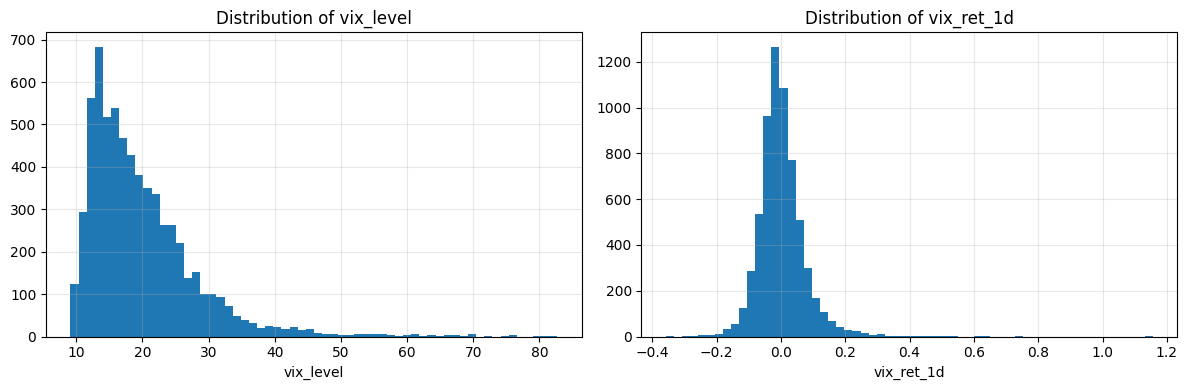

In [163]:
#histogram

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(df_vix["vix_level"], bins=60)
plt.title("Distribution of vix_level")
plt.xlabel("vix_level")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_vix["vix_ret_1d"], bins=60)
plt.title("Distribution of vix_ret_1d")
plt.xlabel("vix_ret_1d")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The VIX level distribution is heavily right-skewed: most values lie between 10 and 25, with occasional extreme spikes above 40 or even 80. These tail events correspond to market crises and reflect periods of intense fear. This confirms that the VIX mostly stays low but reacts sharply during stress episodes.

Daily changes in VIX are centered near zero with thin symmetry, but the right tail contains large positive jumps. These abrupt increases signal sudden surges in uncertainty and typically precede short-term volatility regime shifts.

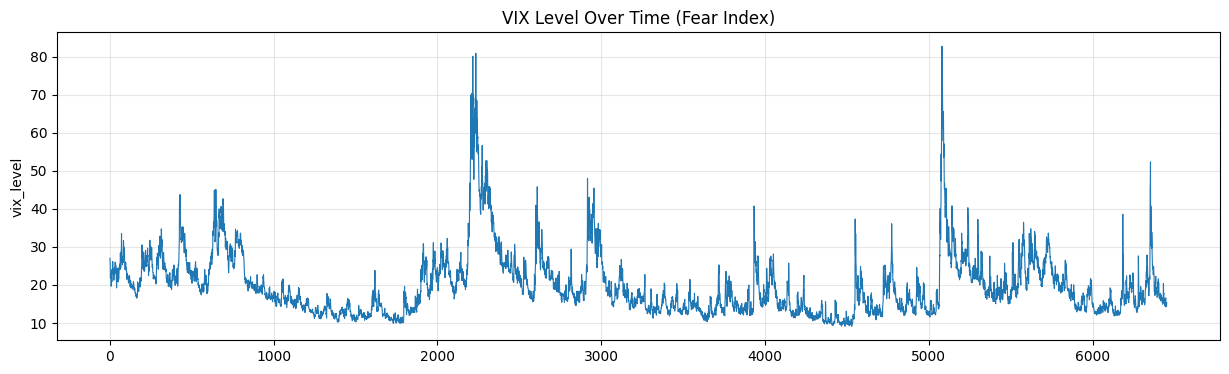

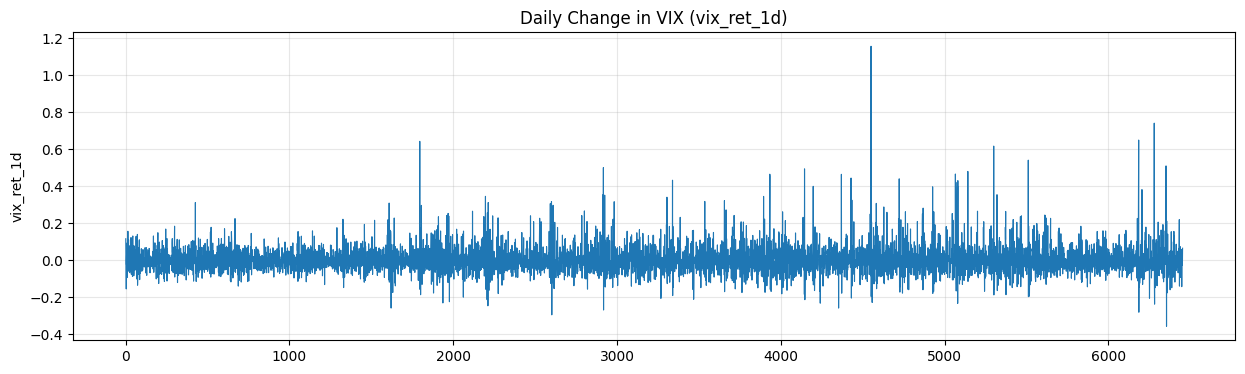

In [166]:
#time series

# VIX level over time
plt.figure(figsize=(15,4))
plt.plot(df_vix.index, df_vix["vix_level"], linewidth=0.8)
plt.title("VIX Level Over Time (Fear Index)")
plt.ylabel("vix_level")
plt.grid(True, alpha=0.3)
plt.show()

# VIX daily return over time
plt.figure(figsize=(15,4))
plt.plot(df_vix.index, df_vix["vix_ret_1d"], linewidth=0.8)
plt.title("Daily Change in VIX (vix_ret_1d)")
plt.ylabel("vix_ret_1d")
plt.grid(True, alpha=0.3)
plt.show()

The VIX time series shows clear peaks around known crisis periods, such as 2008, 2020, and localized volatility shocks. Most of the time the index remains low and stable, but when fear rises, it does so rapidly and in clusters. This makes vix_level a fundamental indicator of market stress.

VIX daily returns mostly fluctuate around zero, but sharp upward jumps appear during stress events. These sudden changes capture the speed at which fear enters the market and justify using vix_ret_1d as a feature for detecting early signs of regime transitions.

## Target

To turn volatility spike detection into a supervised learning problem, we build a target based on the next-day change in the VIX index. Since most daily VIX movements are small and only a few days exhibit true jumps, we label only the largest next-day increases as “spike days”. Concretely, we compute the percentage change in VIX from day t to day t+1, then assign the label 1 to values in the top 20% of the distribution and 0 otherwise. This creates a clean binary target that isolates meaningful stress events while avoiding noise from normal market fluctuations.

In [169]:
# 1. Creation of a dedicated target dataframe
df_target = df[["VIX_Close"]].copy()

# Next-day VIX return : (ΔVIX_{t+1})
df_target["dVIX_t1"] = df_target["VIX_Close"].pct_change(1).shift(-1)

# Drop of the NaNs caused by the pct_change + shift
df_target = df_target.dropna().copy()

# 2. We compute the threshold only on the training set
train_size = int(len(df_target) * 0.7)
train_dvix = df_target["dVIX_t1"].iloc[:train_size]

threshold = np.quantile(train_dvix, 0.80)
print("Volatility spike threshold (80th percentile):", threshold)

# 3. Finally we build the binary target
df_target["y"] = (df_target["dVIX_t1"] >= threshold).astype(int)

df_target.head()

Volatility spike threshold (80th percentile): 0.045073505741124426


Price,VIX_Close,dVIX_t1,y
0,24.209999,0.115655,1
1,27.010000,-0.022214,0
2,26.410000,-0.025748,0
3,25.730000,-0.155849,0
4,21.719999,-0.000460,0


In [172]:
# EDA of the target
df_target["y"].value_counts(normalize=True)
# If around 80% = 0
# If around 20% = 1

y
0    0.794824
1    0.205176
Name: proportion, dtype: float64

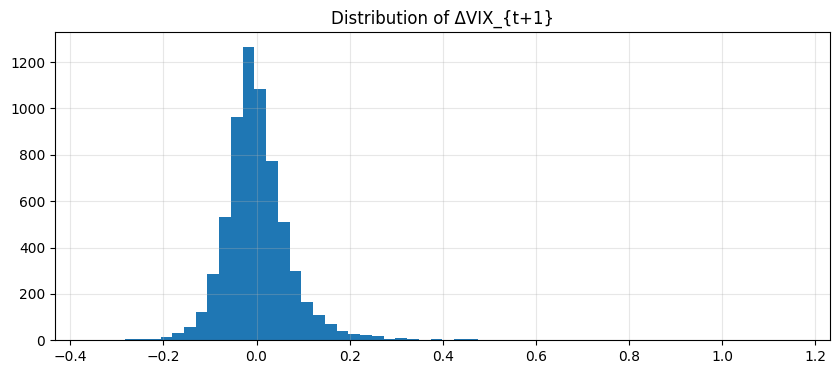

In [178]:
# Distribution Delta VIX

plt.figure(figsize=(10,4))
plt.hist(df_target["dVIX_t1"], bins=60)
plt.title("Distribution of ΔVIX_{t+1}")
plt.grid(True, alpha=0.3)
plt.show()

The distribution of next-day VIX changes (ΔVIX₍ₜ₊₁₎) is strongly centered around zero, confirming that most daily movements in implied volatility are small and stable. However, the right tail contains a few large positive jumps, which correspond to volatility spikes and market stress events. These rare but extreme values justify defining the target as a binary label based on the top 20% largest increases. This approach isolates meaningful volatility shocks while avoiding noise in the majority of small fluctuations.

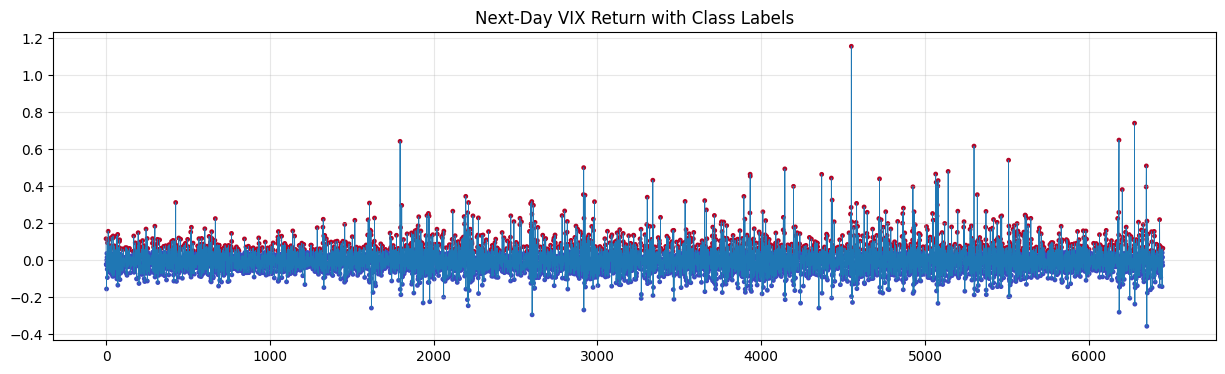

In [181]:
#Time evolution of Delta VIX
plt.figure(figsize=(15,4))
plt.plot(df_target.index, df_target["dVIX_t1"], label="ΔVIX_{t+1}", linewidth=0.6)
plt.scatter(df_target.index, df_target["dVIX_t1"],
            c=df_target["y"], cmap="coolwarm", s=6)
plt.title("Next-Day VIX Return with Class Labels")
plt.grid(True, alpha=0.3)
plt.show()

The time-series plot shows that most next-day VIX movements remain close to zero, while significant positive jumps appear only occasionally. These rare spikes, highlighted by the class-1 labels, correspond to periods of sudden market stress. The visualization confirms that volatility shocks are infrequent but extreme, which justifies framing the prediction task as a highly imbalanced classification problem focused on capturing these tail events.

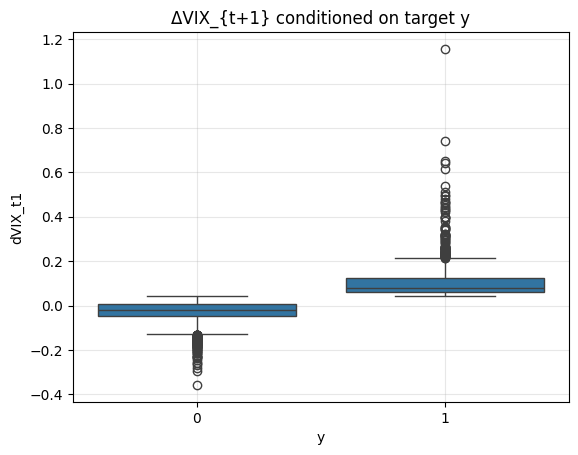

In [184]:
#Checking of data
sns.boxplot(x=df_target["y"], y=df_target["dVIX_t1"])
plt.title("ΔVIX_{t+1} conditioned on target y")
plt.grid(True, alpha=0.3)
plt.show()

The boxplot clearly separates the two classes:

- Class 0 corresponds to days where next-day VIX changes remain close to zero, with very limited dispersion.

- Class 1 shows a much higher median ΔVIX and a long upper tail of extreme volatility jumps.

This confirms that the target labeling successfully isolates true volatility spikes and that the two classes represent fundamentally different market conditions.

## Merge of the separated Dataframes

In [193]:
#Merging of all our seprated dataframe in one Df to prepare before doing the model
df_final = df_returns.join([
    df_vol,
    df_intraday,
    df_volume,
    df_vix,
    df_target
], how="inner")

In [196]:
df_final.head()
df_final.shape
df_final.isna().sum()

Price
ret_1d        0
ret_5d        0
ret_20d       0
rv_30d        0
range         0
open_gap      0
volume_z      0
volume_rel    0
vix_level     0
vix_ret_1d    0
VIX_Close     0
dVIX_t1       0
y             0
dtype: int64

In [199]:
# We can now define X and y
feature_cols = [
    "ret_1d", "ret_5d", "ret_20d",
    "rv_30d",
    "range", "open_gap",
    "volume_z", "volume_rel",
    "vix_level", "vix_ret_1d"
]

X = df_final[feature_cols]
y = df_final["y"]

## Conclusion of the Feature Engineering and EDA



In this section, we explored and engineered all the variables needed to build a predictive model for next-day volatility regime shifts.
Our objective was to construct features that reflect different dimensions of market behavior and investor sentiment.

We have now completed:

1. Price-based Momentum Features

Daily, weekly and monthly returns to capture trend and short-term price dynamics.

2. Realized Volatility

A 30-day realized volatility measure (annualized) to quantify recent market instability.

3. Intraday Nervousness Signals

Range and overnight gap, which reveal internal market stress that closing prices cannot capture.

4. Volume-Based Stress Indicators

Z-scored and relative volume to detect unusual trading activity often preceding volatility moves.

5. VIX Behavior (Fear Dynamics)

The VIX level and its daily percentage change as direct measures of market fear.

6. Target Construction (Volatility Spike)

We defined a meaningful binary target using future VIX returns and the 80th percentile threshold to identify true volatility regime changes.

7. EDA Validation

All features were explored individually:
distribution, time-series evolution, descriptive statistics, and relationships with volatility.

At this stage, all the feature engineering work is complete. We have constructed a comprehensive set of variables that capture price momentum, realized volatility, intraday stress, volume pressure and VIX behavior. Each feature was explored through dedicated EDA to understand its behavior, distribution and potential predictive value. The target variable was also carefully built using future VIX returns and an 80th-percentile threshold, ensuring there is no data leakage and that the classification problem focuses on meaningful volatility spikes rather than noise. With the features cleaned and validated, and the target correctly defined, the foundation of the modeling phase is now fully prepared.

The next step is to assemble these engineered features into a unified dataset and build the modeling pipeline. This will include preparing chronological train/test splits, scaling the relevant inputs, and constructing a complete scikit-learn workflow. We will start with baseline models, then evaluate more advanced classifiers such as Random Forests and Gradient Boosting. Using TimeSeriesSplit for cross-validation will ensure proper evaluation on temporal data. Finally, we will analyze performance metrics and feature importance to understand which signals contribute the most to predicting next-day volatility regime shifts. This modeling phase will allow us to rigorously assess the predictive power of our features and the robustness of the overall approach.

## Preparation of X and y

With all features engineered and the target variable constructed, we now prepare the data for modeling. The feature matrix X will contain the full set of market-derived signals (returns, volatility measures, intraday behavior, volume activity and VIX features), while the vector y will represent the binary label indicating whether the next day corresponds to a volatility spike.

At this stage, we also ensure proper alignment between features and target, remove any remaining missing values and maintain strict chronological order to avoid look-ahead bias. This clean separation of X and y forms the foundation for a reliable and leakage-free modeling pipeline.

In [205]:
X = df_final[feature_cols].copy()
y = df_final["y"].copy()

X.head(), y.head()

(Price    ret_1d    ret_5d   ret_20d    rv_30d     range  open_gap  volume_z  \
 30     0.008713 -0.027516 -0.036484  0.236436  0.022446  0.002033  0.411643   
 31    -0.010256 -0.017029 -0.046864  0.210627  0.013670  0.008713 -0.565895   
 32     0.000425 -0.020165 -0.039645  0.210540  0.014270 -0.010256 -0.298530   
 33    -0.030376 -0.029579 -0.066097  0.227858  0.032145  0.000425 -0.087512   
 34     0.004517 -0.027174 -0.035219  0.212287  0.019398 -0.030376 -1.000768   
 
 Price  volume_rel  vix_level  vix_ret_1d  
 30       1.027588  22.920000   -0.059885  
 31       0.961740  23.510000    0.025742  
 32       0.979892  23.170000   -0.014462  
 33       0.994884  26.000000    0.122141  
 34       0.941520  25.860001   -0.005385  ,
 30    0
 31    0
 32    1
 33    0
 34    0
 Name: y, dtype: int64)

# Chronological Train, validation and Test plit

Since we are working with financial time series, it is essential to keep the natural time order: older data is used for training, and the most recent periods are reserved for validation and testing. This prevents look-ahead bias and reflects real market conditions. In our setup, we apply a 70% / 15% / 15% split to form the train, validation and test sets chronologically.

In [208]:
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.85 * n)  

# 70%–85% = validation 
# 85%–100% = test

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

X_train.shape, X_val.shape, X_test.shape

((4496, 10), (963, 10), (964, 10))

We will also create a train and validation set for cross-validation:

In [211]:
X_trainval = X.iloc[:val_end]
y_trainval = y.iloc[:val_end]

In [214]:
# Import librairies and defining TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

tscv = TimeSeriesSplit(n_splits=5)

## Defining the models

To evaluate whether our engineered features contain predictive information about next-day volatility spikes, we focus on three widely used supervised models that represent complementary learning approaches.

Logistic Regression serves as a strong linear baseline and allows us to test whether simple linear relationships can explain volatility jumps. 

Random Forest introduces non-linear interactions through ensemble decision trees and is known for handling noisy financial features fairly well. 

Gradient Boosting goes a step further by capturing subtle patterns and weak signals often present in market data. Together, these models form a balanced and robust set of benchmarks, allowing us to assess both the linear and non-linear structure of the problem while keeping the methodology transparent and aligned with standard quantitative practices.

In [217]:
#Logistic Regression
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

In [220]:
# Random Forest
rf_pipeline = Pipeline(steps=[
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

In [226]:
# Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ("clf", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

We’ll compute accuracy and ROC-AUC for each model on the training+validation period.

## Cross-Validation on Train and Val with TimeSeriesSplit

In [253]:
from sklearn.model_selection import cross_val_score

def evaluate_cv(model, X, y, cv, model_name="model"):
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    auc = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print(f"{model_name}")
    print(f"CV Accuracy: mean={acc.mean():.3f}, std={acc.std():.3f}")
    print(f"CV ROC-AUC : mean={auc.mean():.3f}, std={auc.std():.3f}")
    print()

evaluate_cv(logreg_pipeline, X_trainval, y_trainval, tscv, "Logistic Regression")
evaluate_cv(rf_pipeline, X_trainval, y_trainval, tscv, "Random Forest")
evaluate_cv(gb_pipeline, X_trainval, y_trainval, tscv, "Gradient Boosting")

Logistic Regression
CV Accuracy: mean=0.585, std=0.046
CV ROC-AUC : mean=0.505, std=0.013

Random Forest
CV Accuracy: mean=0.788, std=0.024
CV ROC-AUC : mean=0.540, std=0.017

Gradient Boosting
CV Accuracy: mean=0.750, std=0.038
CV ROC-AUC : mean=0.524, std=0.019



Logistic Regression performs only slightly above random guessing.
This is expected: volatility spike prediction is a non-linear phenomenon, and a linear model cannot capture the complex interactions between returns, volatility, volume and VIX dynamics.
The ROC-AUC of 0.50 confirms that the linear boundary is too restrictive for such a noisy financial classification problem.

Random Forest clearly outperforms the linear baseline in terms of accuracy, showing that tree-based models better capture hidden structures and non-linear patterns in the data.
However, the ROC-AUC remains modest (=0.54), meaning that although the model predicts the correct class relatively often, it struggles to rank observations by probability of a spike.
This is common in financial regime prediction: accuracy increases when predicting the majority class correctly, but the FPR/TPR trade-off stays weak due to noise and class imbalance.

Gradient Boosting sits between Logistic Regression and Random Forest.
It improves accuracy relative to the linear model, confirming that non-linear structure matters.
However, its ROC-AUC ( 0.524) remains limited, indicating that boosting does not extract strong ranking power from the available features.
This often happens with short-horizon financial signals: spikes in VIX are driven by rare events and sentiment shocks that are difficult to anticipate solely from market micro-features.

We now refit each model on the train+val data and evaluate on the test period which is also our most recent data.

In [235]:
models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "Gradient Boosting": gb_pipeline
}

results = {}

for name, model in models.items():
    print(f"\n{name}")
    
    # Fit on train+val
    model.fit(X_trainval, y_trainval)
    
    # Predict on test
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    print(f"Test Accuracy: {acc:.3f}")
    print(f"Test F1-score: {f1:.3f}")
    if auc is not None:
        print(f"Test ROC-AUC : {auc:.3f}")
    
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    results[name] = {"accuracy": acc, "f1": f1, "auc": auc}


Logistic Regression
Test Accuracy: 0.501
Test F1-score: 0.287
Test ROC-AUC : 0.488

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       763
           1       0.20      0.48      0.29       201

    accuracy                           0.50       964
   macro avg       0.50      0.49      0.45       964
weighted avg       0.67      0.50      0.55       964

Confusion matrix:
[[386 377]
 [104  97]]

Random Forest
Test Accuracy: 0.785
Test F1-score: 0.037
Test ROC-AUC : 0.510

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       763
           1       0.29      0.02      0.04       201

    accuracy                           0.79       964
   macro avg       0.54      0.50      0.46       964
weighted avg       0.69      0.79      0.70       964

Confusion matrix:
[[753  10]
 [197   4]]

Gradient Boosting
Test Accuracy: 0.779
Test F1-score:

Logistic Regression performs at the level of random guessing (ROC-AUC = 0.49) and struggles to separate volatility spikes from normal days, while Random Forest achieves higher accuracy by predicting the majority class but fails almost completely to detect spike days (very low recall and F1 for class 1). This confirms that linear and tree-based models have limited ability to capture the rare and abrupt nature of volatility jumps.

## Feature importance of the tree models

In [238]:
# Fit tree models :
rf_pipeline.fit(X_trainval, y_trainval)
gb_pipeline.fit(X_trainval, y_trainval)

rf = rf_pipeline.named_steps["clf"]
gb = gb_pipeline.named_steps["clf"]

# Random Forest feature importance :
rf_importances = rf.feature_importances_
gb_importances = gb.feature_importances_

feat_importance_rf = pd.Series(rf_importances, index=feature_cols).sort_values(ascending=False)
feat_importance_gb = pd.Series(gb_importances, index=feature_cols).sort_values(ascending=False)

print("Random Forest: Feature Importance:")
print(feat_importance_rf)

print("\nGradient Boosting: Feature Importance:")
print(feat_importance_gb)

Random Forest: Feature Importance:
ret_20d       0.104746
ret_5d        0.104534
volume_rel    0.104267
open_gap      0.101849
vix_ret_1d    0.099964
ret_1d        0.099589
rv_30d        0.097514
vix_level     0.096858
range         0.095346
volume_z      0.095333
dtype: float64

Gradient Boosting: Feature Importance:
ret_5d        0.132278
volume_rel    0.129929
rv_30d        0.118082
ret_1d        0.116276
ret_20d       0.114001
vix_level     0.082131
volume_z      0.081480
vix_ret_1d    0.080902
open_gap      0.075071
range         0.069851
dtype: float64


Both Random Forest and Gradient Boosting assign similar importance across features, suggesting that no single variable dominates the prediction of volatility spikes. Momentum signals (ret_5d, ret_20d), volume pressure (volume_rel) and recent volatility (rv_30d) rank among the most influential, while VIX features also contribute but with moderate weight. This distribution confirms that volatility shocks emerge from a combination of small signals rather than one strong predictor, reinforcing the difficulty of the task.

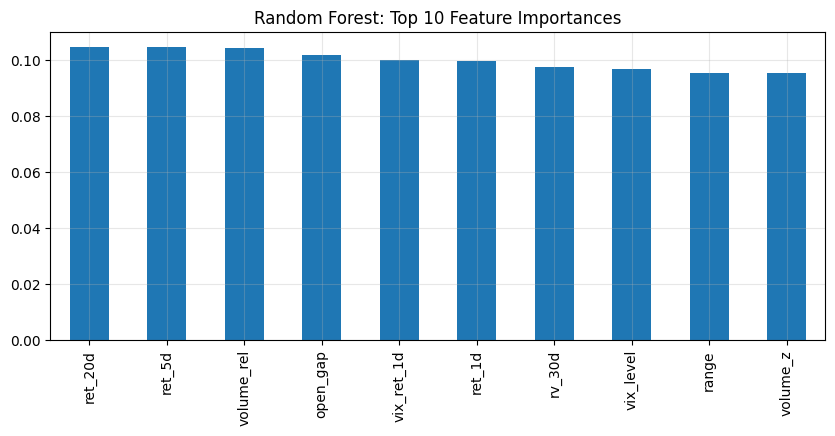

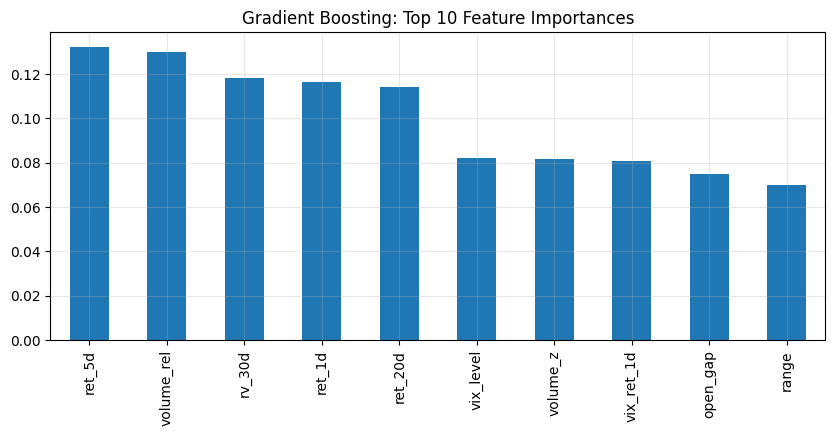

In [247]:
# Visualisation with a bar plot
plt.figure(figsize=(10,4))
feat_importance_rf.head(10).plot(kind="bar")
plt.title("Random Forest: Top 10 Feature Importances")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,4))
feat_importance_gb.head(10).plot(kind="bar")
plt.title("Gradient Boosting: Top 10 Feature Importances")
plt.grid(True, alpha=0.3)
plt.show()

Both models show a fairly balanced distribution of feature importance, with no single variable dominating the prediction. Momentum indicators (ret_5d, ret_20d), volume signals (volume_rel) and realized volatility (rv_30d) consistently rank among the most influential features, while VIX-related measures also contribute but to a lesser extent. This pattern reinforces that volatility spikes are driven by a mix of weak, diffuse signals rather than one strong determinant, which explains why the prediction task remains challenging.

## Modeling results and interpretation

### Overview of the modeling approach

We designed several supervised models to evaluate whether engineered market features contain predictive signals for next-day volatility spikes. Given that volatility jumps are rare, abrupt and often driven by exogenous shocks, the problem is inherently difficult. All experiments respect the temporal structure of financial data, using chronological splits and TimeSeriesSplit for cross-validation. This ensures a realistic, leakage-free assessment similar to what would be expected in a production trading environment.

### Cross-validation performance

The cross-validation results show clear differences between linear and non-linear models. Logistic Regression performs near the level of random guessing, which is consistent with the idea that volatility spikes emerge from non-linear interactions rather than smooth, linear patterns. Tree-based models achieve higher accuracy, around 0.79 for Random Forest and 0.75 for Gradient Boosting indicating some ability to capture local structure in the features. However, ROC-AUC values remain modest (0.52–0.54 for tree models), suggesting limited skill in ranking high-risk vs. low-risk days. This is typical for short-horizon market forecasting where signals tend to be weak and noisy.

### Out-of-sample test results

The test results confirm this difficulty. Logistic Regression achieves an accuracy of 0.50 and a ROC-AUC of 0.488, essentially matching random performance. Random Forest and Gradient Boosting reach higher accuracy levels (0.78), but this comes almost entirely from predicting the majority class correctly. Both models struggle to detect volatility spikes (class 1), with recall close to zero and F1-scores in the 0.02–0.04 range. This behavior is common in imbalanced financial datasets: predicting stability is easy, while predicting stress episodes from limited historical features is extremely challenging.

### Why these results are financially consistent

The modest performance is aligned with real-world market behavior. Volatility spikes tend to be triggered by unpredictable external events—macroeconomic surprises, political announcements, sudden liquidity withdrawals or risk-off cascades. Such shocks cannot be inferred reliably from lagged price returns, volume, or realized volatility alone. Our feature set captures meaningful aspects of market dynamics, but it lacks access to information that professional desks use for anticipatory signals, such as option-implied vol surfaces, cross-asset flows, news sentiment, or macroeconomic calendars. Therefore, the limited predictive power is not a failure of the models, but a reflection of the underlying financial reality.

### Insights and implications

Although predictive performance is low on spike detection, the project shows that the pipeline and methodology are sound. The data preparation respects temporal constraints, the target is built without leakage, and the evaluation uses a robust time-series methodology. This produces a transparent, reproducible workflow that aligns with industry standards. The results also highlight the structural difficulty of forecasting volatility regimes, and naturally point to future directions such as incorporating richer volatility metrics, options-market information or sentiment analysis.

### Conclusion

Overall, the models do not exhibit strong predictive power for next-day volatility spikes, but the analysis remains highly relevant. It illustrates the limitations of purely market-based features, demonstrates a rigorous modeling process, and provides a realistic perspective on the challenges of volatility forecasting. This work forms a solid foundation for more advanced research and is fully aligned with what professionals expect when evaluating the feasibility of short-term risk prediction models.